# Train a `tf.Estimator` on MNIST dataset  
In this notebook we introduce the `tf.Estimator` API  by training a small CNN to make predictions on the MNIST dataset 

Adopted from here: https://www.tensorflow.org/tutorials/estimators/cnn

### Confirm our runtime has a GPU attached

In [1]:
!nvidia-smi

Tue Nov 13 01:47:24 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Import necessary libraries

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
plt.style.use('default')
%matplotlib inline

tf.logging.set_verbosity(tf.logging.INFO)

## Let's load the dataset and do a quick Exploratory Data Analysis (EDA)!

## Quick description of MNIST:   
MNIST is a database of 70,000 handwritten digits (0-9) consisting of 28x28 black and white images and their corresponding class labels.  
It is often used as a "Hello World!" to Convolutional Neural Networks (CNNs) since it is widely accesible and has a low memory footprint despite its relatively large sample size.  
http://yann.lecun.com/exdb/mnist/

In [3]:
# use keras `mnist` module to download MNIST dataset and load into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

11493376/11490434 [==============================] - 0s 0us/step
60000 train samples
10000 test samples


### Visualize some of the images in a grid.  
See many examples of plotting in Colab [here](https://colab.research.google.com/notebooks/charts.ipynb)

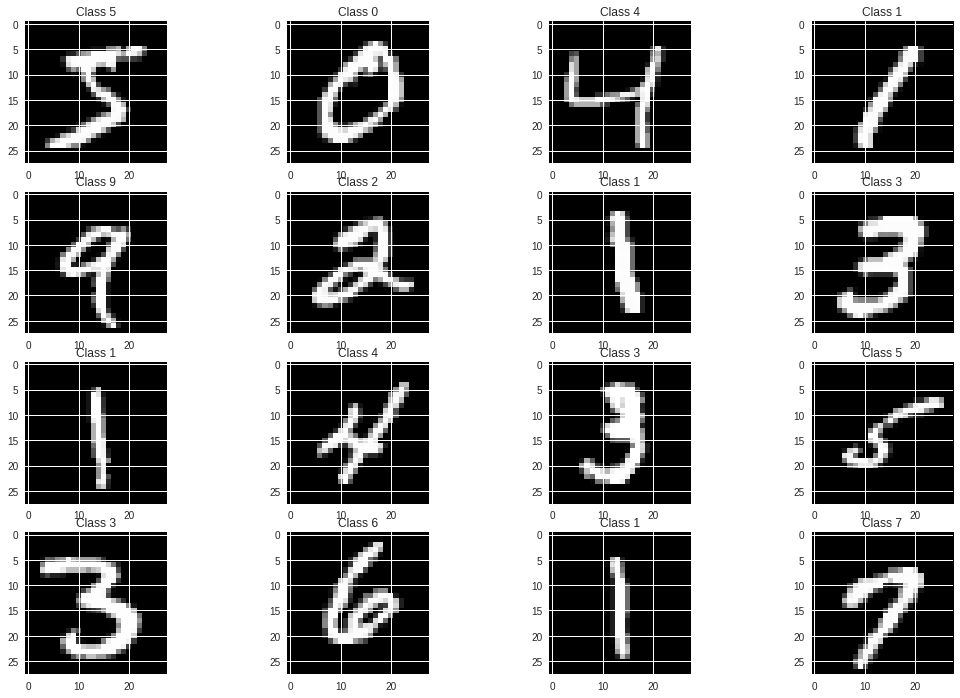

In [4]:
plt.figure(figsize=(18,12))
for idx, img in enumerate(X_train[:16]):
    plt.subplot(4, 4, idx + 1)
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[idx]))

### Observe the class distributions in the train and test set

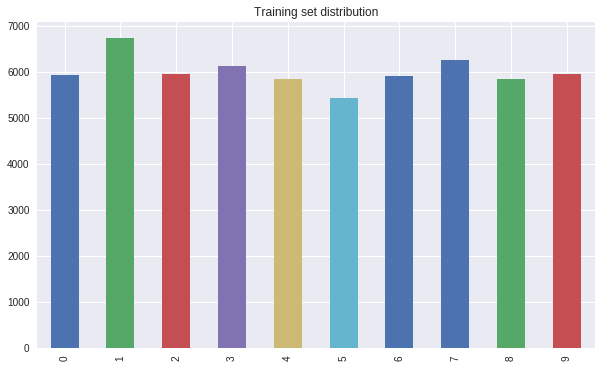

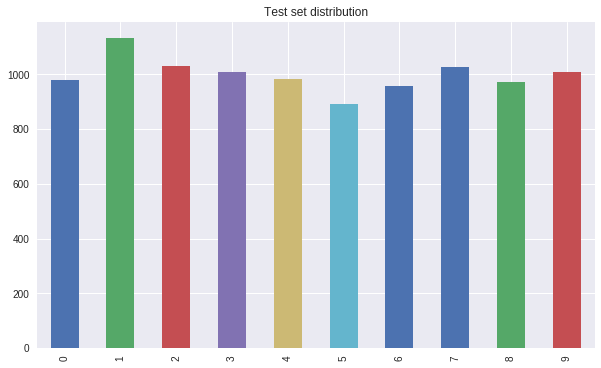

In [5]:
# convert to pandas dataframe to leverage its `value_counts` and `sort_index` functions in plotting
df_train = pd.DataFrame(y_train, columns=['label'])
df_test = pd.DataFrame(y_test, columns=['label'])
df_train.label.value_counts().sort_index().plot(kind='bar', title='Training set distribution', figsize=(10, 6))
plt.show()
df_test.label.value_counts().sort_index().plot(kind='bar', title='Test set distribution', figsize=(10, 6))
plt.show()

### Visualize class distributions on 2D grid using Principal Component Analysis (PCA) dimensionality reduction

In [30]:
# flatten samples from 2-d (28, 28) to 1-d (784,)
n_samples, height, width = X_train.shape
X_train_flattened = X_train.reshape((n_samples, height*width))
X_train_flattened.shape

(60000, 784)

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_train_flattened)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.09704664 0.07095924]


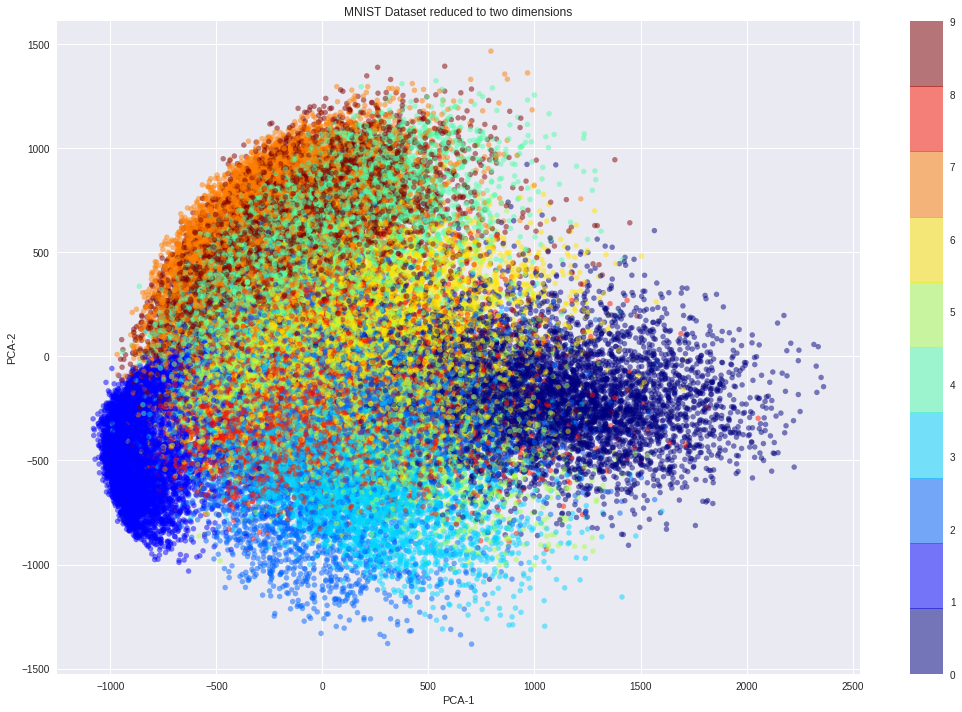

In [32]:
plt.figure(figsize=(18, 12))
plt.scatter(x=pca_result[:, 0], 
            y=pca_result[:, 1], 
            c=y_train[:], 
            edgecolor='none', 
            alpha=0.5,
            cmap=plt.get_cmap('jet', 10), 
            s=30)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.colorbar()
plt.title("MNIST Dataset reduced to two dimensions")
plt.show()


## Define our model function which describes the CNN architecture, loss function, optimizer, etc.  
Our network highly resembles the architecture shown below except for a few minor differences in the number of filters, kernel sizes, pooling layers, etc.
![image](https://codetolight.files.wordpress.com/2017/11/network.png?w=1108)  
Image source: https://codetolight.wordpress.com/2017/11/29/getting-started-with-pytorch-for-deep-learning-part-3-neural-network-basics/  
|  
|  
### Our CNN architecture is as follows (adapted from [here](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py)):  
```python
  # Input Layer
  input_layer = tf.reshape(tensor=features["x"], 
                           shape=[-1, 28, 28, 1],
                          name='input')

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu,
      name='conv_1')
  # Convolutional Layer #2
  conv2 = tf.layers.conv2d(
      inputs=conv1,
      filters=64,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu,
      name='conv_2')
  pool1 = tf.layers.max_pooling2d(inputs=conv2, 
                                  pool_size=[2, 2], 
                                  strides=2,
                                 name='pool_1')
  dropout1 = tf.layers.dropout(inputs=pool1, 
                              rate=0.25, 
                              training=mode == tf.estimator.ModeKeys.TRAIN,
                              name='dropout_1')
  flatten = tf.layers.Flatten()(dropout1)
  dense = tf.layers.dense(inputs=flatten, 
                          units=128, 
                          activation=tf.nn.relu,
                         name='dense_1')
  dropout2 = tf.layers.dropout(inputs=dense, 
                            rate=0.5, 
                            training=mode == tf.estimator.ModeKeys.TRAIN,
                            name='dropout_2')
  logits = tf.layers.dense(inputs=dropout2, 
                           units=10,
                          name='logits')
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
```

### Some notes about writing model functions for `tf.Estimator` (see official docs [here](https://www.tensorflow.org/guide/custom_estimator)):   
A model function must have the following signature:  
```python
def my_model_fn(
   features, # This is batch_features from input_fn
   labels,   # This is batch_labels from input_fn
   mode,     # An instance of tf.estimator.ModeKeys
   params):  # Additional configuration
```  
But let's say we'd like to pass additional parameters to the model function, for example a configurable learning rate or input layer dimensions:  
```python
def my_model_fn(features, labels, mode, learning_rate, input_height, input_width):
    # neural network defined here...
```
If we pass above model function to `tf.Estimator` as-is, it will throw an `Exception` complaining about unexpected arguments. But we can simply override as follows: 
```python
input_height = 480
input_width = 640
learning_rate = 0.001
def model_fn(features, labels, mode):
     return my_model_fn(features, labels, mode, learning_rate, input_height, input_width)
```
Then instantiate the `tf.Estimator` as per usual:
```python
estimator = tf.estimator.Estimator(model_fn=model_fn, 
                                   model_dir=model_dir,
                                   ...,
                                  )
```

In [0]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  input_layer = tf.reshape(tensor=features["x"], 
                           shape=[-1, 28, 28, 1],
                          name='input')
  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu,
      name='conv_1')
  # Convolutional Layer #2
  conv2 = tf.layers.conv2d(
      inputs=conv1,
      filters=64,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu,
      name='conv_2')
  pool1 = tf.layers.max_pooling2d(inputs=conv2, 
                                  pool_size=[2, 2], 
                                  strides=2,
                                 name='pool_1')
  dropout1 = tf.layers.dropout(inputs=pool1, 
                              rate=0.25, 
                              training=mode == tf.estimator.ModeKeys.TRAIN,
                              name='dropout_1')
  flatten = tf.layers.Flatten()(dropout1)
  dense = tf.layers.dense(inputs=flatten, 
                          units=128, 
                          activation=tf.nn.relu,
                         name='dense_1')
  dropout2 = tf.layers.dropout(inputs=dense, 
                            rate=0.5, 
                            training=mode == tf.estimator.ModeKeys.TRAIN,
                            name='dropout_2')
  logits = tf.layers.dense(inputs=dropout2, 
                           units=10,
                          name='logits')
  embeddings = tf.layers.dense(inputs=flatten, 
                          units=1, 
                          activation=tf.nn.relu,
                         name='embeddings')
  embeddings = tf.layers.Flatten(name='embeddings')(dense)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor"),
      "embeddings": embeddings
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
  # add an image summary to visualize input images
  tf.summary.image('vis_input', input_layer, max_outputs=4)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdadeltaOptimizer(learning_rate=1)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

## Visualize the CNN model architecture

In [0]:
import numpy as np
import tensorflow as tf
from IPython.display import  HTML
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

Below is a bit of a hack however it enables us to render the computational graph in a notebook cell

In [11]:
with tf.Session() as sess:
  with tf.Graph().as_default():
    mode = tf.estimator.ModeKeys.TRAIN
    features = {'x': X_train[0].reshape(1, 28, 28, 1).astype('float32')}
    labels = y_train[0].reshape((-1, 1)).astype('int32')
    cnn_model_fn(features, labels, mode)
    show_graph(tf.get_default_graph())

## Let's train the model!

### First, define our model directory where the weights are saved during training 

In [0]:
MODEL_DIR = "/tmp/mnist_convnet_model"

### Before starting training, launch Tensorboard to visualize training process

Using `ngrok` we can tunnel from the hosted runtime to an external address accessible in our browser

In [0]:
# download and install ngrok
!wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip 
!unzip -o ngrok-stable-linux-amd64.zip > /dev/null 2>&1

In [0]:
# launch tensorboard in shell
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(MODEL_DIR)
)
import time; time.sleep(5) # wait briefly for tensorboard to launch

In [15]:
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://ae07f5ea.ngrok.io


### Preprocess our images and labels for input into the neural network during training.
Currently our images (`X_train`, `X_test`) are in `uint8` format with values 0 to 255. The neural network expects float values 0.0 to 1.0.  
Similarily, labels are `uint8` and neural network expects `uint32`

In [0]:
# convert images to float32 with values 0.0 to 1.0
X_train_net = X_train.astype('float32')
X_test_net = X_test.astype('float32')
X_train_net /= 255.
X_test_net /= 255.
# convert labels to int32 format
y_train_net = y_train.astype('int32')
y_test_net = y_test.astype('int32')


### Define batch size and number of training steps
* **`batch_size`** is the number of images to feed into the network per training step. In this case we have chosen 128 but for larger images (eg. 640x480) it is likely that this will not fit in memory and a more conservative batch size of 4 or 8 will be chosen.  
* **`num_epochs`** is how many times we'd like the neural network to see the entire training set (in this case 60,000 images) during training. I found experimentally that this model converges after ~15 epochs which is why 20 is chosen.
* **`num_steps`** is how many total training steps will be executed. This is calculated from our batch size and number of epochs. We calculate this since `tf.Estimator` takes `num_steps` as input rather than `num_epochs`

In [0]:
batch_size = 128
num_epochs = 5
num_steps = np.ceil(num_epochs * X_train_net.shape[0] / batch_size)

### Instantiate the `tf.Estimator` and point it to our model function and model directory

In [18]:
# ! rm -rf $MODEL_DIR
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, 
    model_dir=MODEL_DIR)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/mnist_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f606184b4e0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Define input function
In this case we'll use a simple pre-made input function `tf.estimator.inputs.numpy_input_fn` since our dataset can easily fit in memory.  
But in many cases you'll need to write a custom input function for memory or performance reason (see official docs [here](https://www.tensorflow.org/guide/performance/datasets))

In [0]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train_net},
    y=y_train_net,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

### Start the training loop!  
Now that we have defined our model function, input function and training hyperparameters, training can begin.  
Open the Tensorboard link to monitor the training progress (loss, etc.)

In [25]:
# continuous_eval(estimator=mnist_classifier, model_dir=MODEL_DIR, input_fn=train_input_fn, train_steps=num_steps, name='eval')
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:loss = 2.3142965, step = 0
INFO:tensorflow:global_step/sec: 58.7399
INFO:tensorflow:loss = 0.33539754, step = 100 (1.708 sec)
INFO:tensorflow:global_step/sec: 65.0018
INFO:tensorflow:loss = 0.11844538, step = 200 (1.535 sec)
INFO:tensorflow:global_step/sec: 64.6355
INFO:tensorflow:loss = 0.20761037, step = 300 (1.549 sec)
INFO:tensorflow:global_step/sec: 64.9447
INFO:tensorflow:loss = 0.11676061, step = 400 (1.538 sec)
INFO:tensorflow:global_step/sec: 65.6612
INFO:tensorflow:loss = 0.15144601, step = 500 (1.523 sec)
INFO:tensorflow:global_step/sec: 64.9156
INFO:tensorflow:loss = 0.09421627, step = 600 (1.544 sec)
INFO:tensorflow:global_step/sec: 64.7946
IN

### Evaluate the model accuracy using test samples

In [26]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_test_net},
    y=y_test_net,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-13-01:52:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-2344
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-13-01:52:36
INFO:tensorflow:Saving dict for global step 2344: accuracy = 0.9875, global_step = 2344, loss = 0.034837455
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2344: /tmp/mnist_convnet_model/model.ckpt-2344
{'accuracy': 0.9875, 'loss': 0.034837455, 'global_step': 2344}


### Visualize erroneous model predictions
Predict the labels of our test set and visualize where our model is confused

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-2344
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


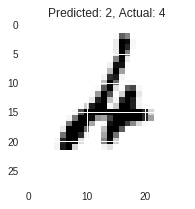

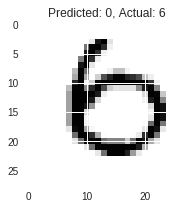

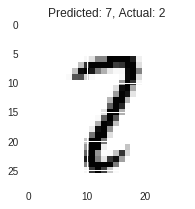

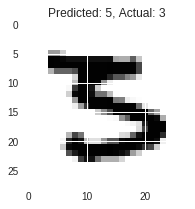

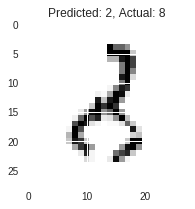

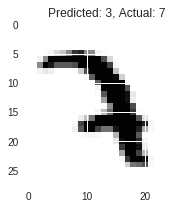

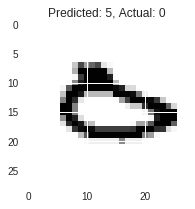

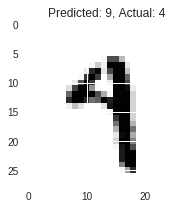

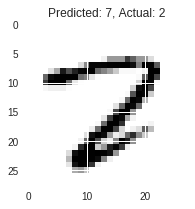

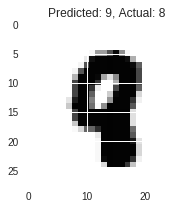

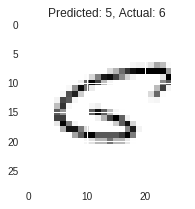

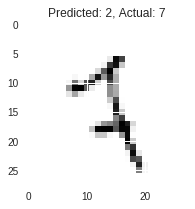

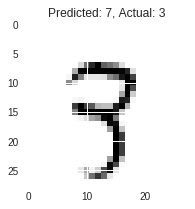

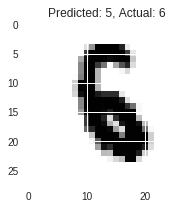

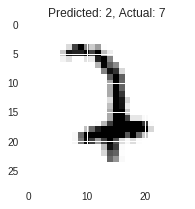

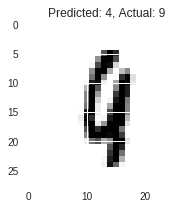

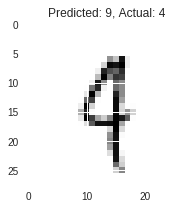

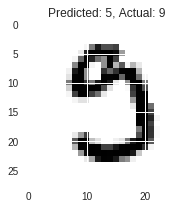

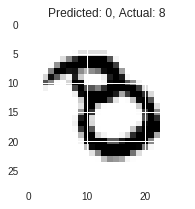

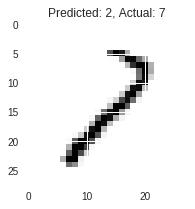

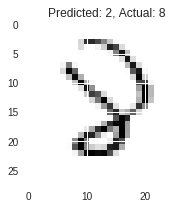

In [37]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_test_net},
    num_epochs=1,
    shuffle=False)
predictions = mnist_classifier.predict(predict_input_fn)
max_predictions_to_show = 20
show_cnt = 0
for predicted, actual, test_img in zip(predictions, y_test, X_test):
  pred_class = predicted['classes']
  probs = predicted['probabilities']
  if pred_class != actual:
    plt.figure(figsize=(3, 3))
    plt.imshow(test_img)
    plt.title("Predicted: {}, Actual: {}".format(pred_class, actual))
    plt.show()
    show_cnt += 1
    if show_cnt > max_predictions_to_show:
      break

## Visualizing embeddings  
Recall our CNN architecture:  
![image](https://codetolight.files.wordpress.com/2017/11/network.png?w=1108)  

The primary function of CNNs is to extract meaningful features from image pixels and compress them into a low dimensional representation (embedding) which can then be classified more effectively.  
These features are often referred to as **bottleneck features** (further reading [here](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)) and can be highly effective for tasks such as reverse image search, facial recognition, and image encoding since the image is highly compressed but still highly explained by its feature vector.  
For instance you can convert a face database into embeddings and use L2 distance to compute similarity between two faces or us K-Nearest-Neighbours to cluster similar images together in a photo album.
### To visualize this, we will run the same PCA as before however instead of computing PCA on the raw image pixels we compute on the features from the final dense layer ("FC Layer" in above figure) of our trained model.  


In [38]:
predictions = mnist_classifier.predict(predict_input_fn)
embeddings = []
for predicted in predictions:
  embeddings.append(predicted['embeddings'])
embeddings = np.array(embeddings)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-2344
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Explained variation per principal component: [0.18091016 0.17045377]


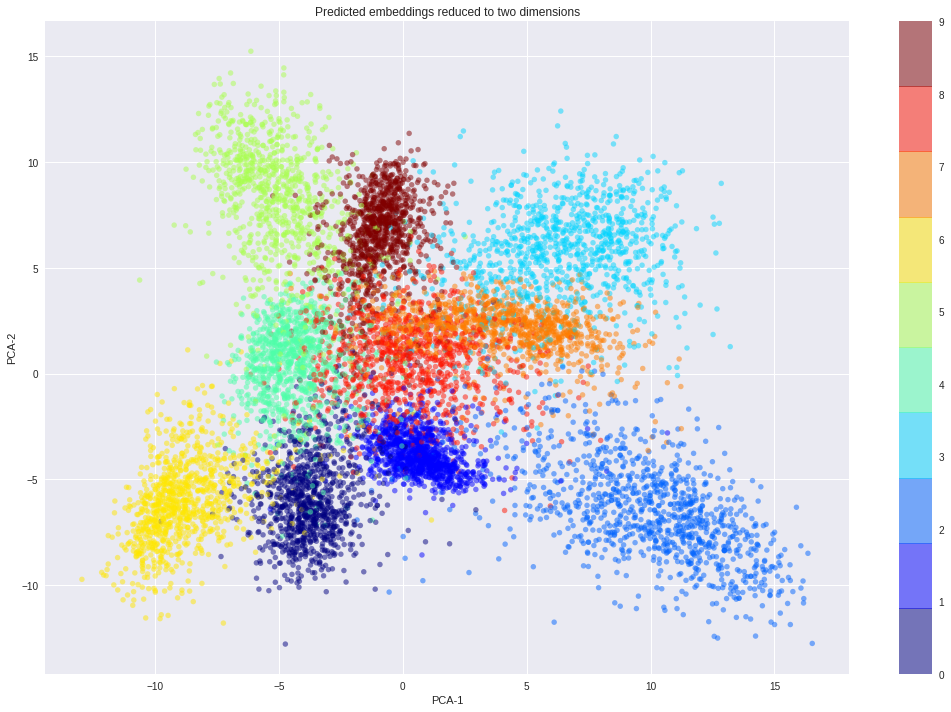

In [36]:
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2)
pca_result2 = pca2.fit_transform(embeddings)
print('Explained variation per principal component: {}'.format(pca2.explained_variance_ratio_))
plt.figure(figsize=(18, 12))
plt.scatter(x=pca_result2[:, 0], 
            y=pca_result2[:, 1], 
            c=y_test[:], 
            edgecolor='none', 
            alpha=0.5,
            cmap=plt.get_cmap('jet', 10), 
            s=30)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.colorbar()
plt.title("Predicted embeddings reduced to two dimensions")
plt.show()

### Notice the increase in explained variation and the class boundaries are more clearly defined than before.
Let's plot the previous PCA results to compare

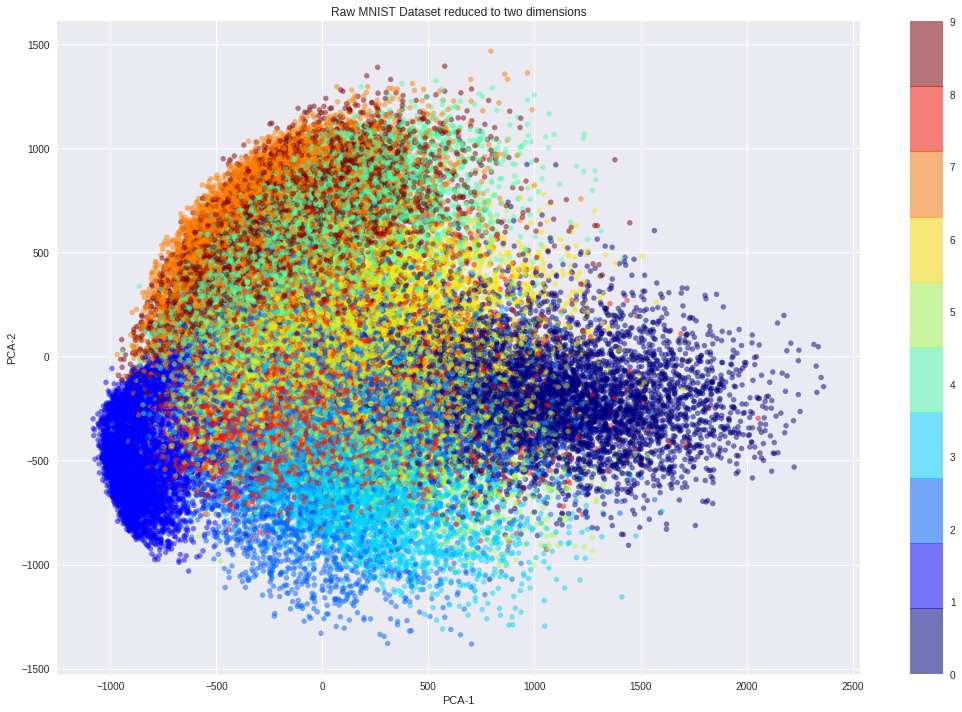

In [39]:
plt.figure(figsize=(18, 12))
plt.scatter(x=pca_result[:, 0], 
            y=pca_result[:, 1], 
            c=y_train[:], 
            edgecolor='none', 
            alpha=0.5,
            cmap=plt.get_cmap('jet', 10), 
            s=30)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.colorbar()
plt.title("Raw MNIST Dataset reduced to two dimensions")
plt.show()

In [41]:
embeddings_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train_net},
    num_epochs=1,
    shuffle=False)
train_embeddings = []
for predicted in mnist_classifier.predict(embeddings_input_fn):
  train_embeddings.append(predicted['embeddings'])
train_embeddings = np.array(train_embeddings)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model/model.ckpt-2344
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [42]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(train_embeddings, y_train_net)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
preds = rfc.predict(embeddings)
from sklearn.metrics import accuracy_score
acc = accuracy_score(preds, y_test_net)
print(acc)

0.9856


0.9856
